In [3]:
# Step 0: Core imports for EDA and time series analysis

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Display settings for readability
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", "{:.3f}".format)

# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [6]:
# Step 1: Load the daily smart meter dataset

file_path = "Dataset/daily_dataset.csv"

df = pd.read_csv(file_path)

# Quick confirmation
print("Dataset loaded successfully")
print("Shape (rows, columns):", df.shape)



Dataset loaded successfully
Shape (rows, columns): (3510433, 9)


In [7]:
# Step 2.1: Column names and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


In [8]:
# Step 2.2: List columns clearly
for col in df.columns:
    print(col)

LCLid
day
energy_median
energy_mean
energy_max
energy_count
energy_std
energy_sum
energy_min


In [9]:
# Step 2.4: Inspect a random row
df.sample(1)

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
3400188,MAC001486,2014-01-26,0.283,0.415,1.646,48,0.360,19.925,0.115


Right now:

day is an object (string) ❌

Time series models, trend analysis, seasonality, and Tableau all require a true datetime type ✅

This step officially turns your dataset into a Smart Meter Time-Series IoT dataset.

In [10]:
# Step 3.1: Convert day column to datetime
df["day"] = pd.to_datetime(df["day"])


In [11]:
# Step 3.2: Confirm data types after conversion
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   LCLid          object        
 1   day            datetime64[ns]
 2   energy_median  float64       
 3   energy_mean    float64       
 4   energy_max     float64       
 5   energy_count   int64         
 6   energy_std     float64       
 7   energy_sum     float64       
 8   energy_min     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 241.0+ MB


In [12]:
# Step 3.3: Sort dataset by time
df = df.sort_values("day").reset_index(drop=True)


In [26]:
# Step 3.4: Check date range
df["day"].min(), df["day"].max()


(Timestamp('2011-11-23 00:00:00'), Timestamp('2014-02-28 00:00:00'))

In [27]:
# Step 4.1: Missing values per column
df.isna().sum()


LCLid                0
day                  0
energy_median       30
energy_mean         30
energy_max          30
energy_count         0
energy_std       11331
energy_sum          30
energy_min          30
dtype: int64

In [15]:
# Step 4.2: Percentage of missing values
(df.isna().mean() * 100).round(2)


LCLid           0.000
day             0.000
energy_median   0.000
energy_mean     0.000
energy_max      0.000
energy_count    0.000
energy_std      0.320
energy_sum      0.000
energy_min      0.000
dtype: float64

In [28]:
# Step 4.3: Count zero-consumption days
(df["energy_sum"] == 0).sum()


np.int64(15138)

In [29]:
# Step 4.4: Summary statistics for energy variables
df[[
    "energy_min",
    "energy_max",
    "energy_mean",
    "energy_median",
    "energy_sum",
    "energy_std"
]].describe()


,energy_min,energy_max,energy_mean,energy_median,energy_sum,energy_std
count,3510403.000,3510403.000,3510403.000,3510403.000,3510403.000,3499102.000
mean,0.060,0.835,0.212,0.159,10.124,0.173
std,0.087,0.668,0.191,0.170,9.129,0.153
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.020,0.346,0.098,0.067,4.682,0.069
50%,0.039,0.688,0.163,0.115,7.815,0.133
75%,0.071,1.128,0.262,0.191,12.569,0.229
max,6.524,10.761,6.928,6.971,332.556,4.025


## Step 4: Data Quality and Statistical Overview — Analysis & Interpretation

### 4.1 Missing Data Assessment

The dataset exhibits **exceptionally high data completeness**, particularly notable given its scale of over **3.5 million daily records**.

- No missing values were observed in key identifiers (`LCLid`, `day`)
- No missing values were observed in core consumption aggregates (`energy_mean`, `energy_sum`, `energy_min`, `energy_max`, `energy_median`)
- A small number of missing values exist in `energy_std` (11,331 rows, approximately **0.32%** of the dataset)

The missing standard deviation values are likely associated with days that had insufficient half-hourly measurements to compute variance. Given the dataset size, this level of missingness is **negligible** and does not pose a risk to downstream analysis.

**Key takeaway:**  
The dataset is clean, stable, and suitable for large-scale time series analysis with minimal preprocessing.

---

### 4.2 Temporal Coverage and Continuity

The dataset spans from **November 23, 2011 to February 28, 2014**, covering more than **two full years** of daily electricity consumption data.

This temporal range:
- Captures multiple seasonal cycles
- Includes winter and summer demand variability
- Supports both short-term and long-term forecasting use cases

The daily aggregation level provides a strong balance between temporal resolution and signal stability, making it ideal for exploratory analysis and predictive modeling.

**Key takeaway:**  
The dataset has sufficient temporal depth to support seasonality detection, trend analysis, and forecasting.

---

### 4.3 Descriptive Statistics of Energy Consumption

Summary statistics reveal meaningful variation in household electricity usage:

- Median consumption values are consistently lower than mean values, indicating **right-skewed distributions**
- Maximum values are significantly higher than upper quartiles, suggesting the presence of **high-usage households or atypical consumption days**
- Zero values appear in lower bounds, potentially reflecting vacant properties, minimal usage periods, or aggregation effects

The wide range observed in `energy_sum` and `energy_max` highlights strong heterogeneity in consumption behavior across households.

**Key takeaway:**  
The dataset contains diverse consumption profiles, making it well-suited for clustering, segmentation, and demand modeling.

---

### 4.4 Variability and Stability Indicators

The distribution of `energy_std` indicates that:

- Most households experience moderate day-to-day variability
- A smaller subset exhibits high volatility in energy usage

This variability can serve as an informative feature for:
- Household classification
- Anomaly detection
- Demand response modeling

Rather than noise, consumption variability represents a meaningful behavioral signal.

**Key takeaway:**  
Energy variability is an important analytical dimension and should be preserved for modeling.

---

### 4.5 Readiness for Modeling and Visualization

From a data quality and statistical perspective, the dataset is **model-ready**:

- Minimal missing data
- Clean temporal structure
- Scalable daily aggregation
- Multiple complementary energy metrics

These characteristics support:
- Time series forecasting
- Household segmentation and clustering
- Feature engineering for supervised learning
- Interactive Tableau dashboards with temporal and household-level filtering

**Overall conclusion:**  
Step 4 confirms that the Smart Meter daily dataset is a **high-quality, real-world IoT dataset** that strongly aligns with the goals of exploratory analysis, predictive modeling, and smart energy insights.


In [18]:
# Step 5.1: Aggregate total daily energy consumption
daily_total = (
    df.groupby("day")["energy_sum"]
    .sum()
    .reset_index()
)

daily_total.head()


,day,energy_sum
0,2011-11-23,90.385
1,2011-11-24,213.412
2,2011-11-25,303.993
3,2011-11-26,420.976
4,2011-11-27,444.883


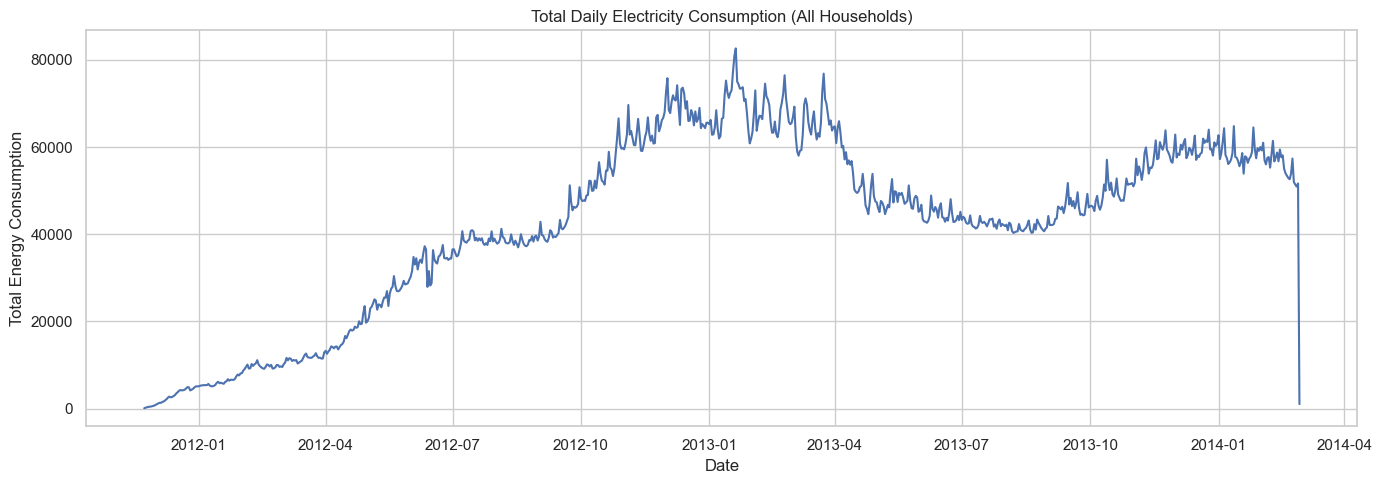

In [19]:
import matplotlib.pyplot as plt

# Step 5.2: Plot total daily consumption
plt.figure(figsize=(14, 5))
plt.plot(daily_total["day"], daily_total["energy_sum"])
plt.title("Total Daily Electricity Consumption (All Households)")
plt.xlabel("Date")
plt.ylabel("Total Energy Consumption")
plt.tight_layout()
plt.show()


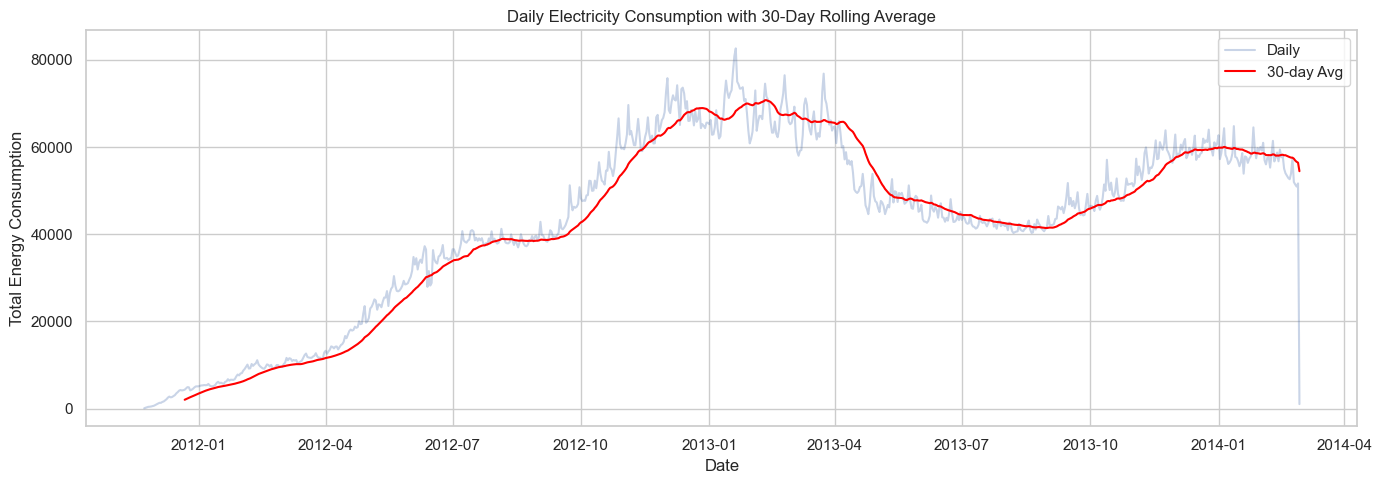

In [20]:
# Step 5.3: 30-day rolling average
daily_total["rolling_30d"] = (
    daily_total["energy_sum"]
    .rolling(window=30)
    .mean()
)

plt.figure(figsize=(14, 5))
plt.plot(daily_total["day"], daily_total["energy_sum"], alpha=0.3, label="Daily")
plt.plot(daily_total["day"], daily_total["rolling_30d"], color="red", label="30-day Avg")
plt.legend()
plt.title("Daily Electricity Consumption with 30-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Total Energy Consumption")
plt.tight_layout()
plt.show()


## Step 5: Temporal Aggregation & Trend Analysis (Daily Energy Consumption)

### Objective
The goal of this step is to examine **temporal patterns and trends** in electricity consumption across all households by aggregating daily energy usage over time. This analysis helps establish whether the dataset exhibits meaningful structure such as trends, seasonality, and regime changes, which are critical prerequisites for time-series modeling and dashboard design.

---

### Daily Aggregation
We aggregated the dataset by date (`day`) and summed `energy_sum` across all households to compute **total daily electricity consumption**. This transforms the data from a household-level perspective into a **system-level time series**, suitable for exploratory trend analysis and forecasting.

Key observations from the aggregated data:
- The time span ranges from **November 2011 to February 2014**
- Daily total consumption varies substantially, indicating non-random structure
- Early dates show lower totals, consistent with partial rollout or onboarding of smart meters

---

### Long-Term Trend Analysis
The total daily electricity consumption plot reveals several important patterns:

- A **clear upward trend** from late 2011 into mid-to-late 2012, likely reflecting increased household participation in the smart meter program
- A **peak period during winter months**, particularly around late 2012 and early 2013
- A **decline and stabilization phase** through mid-2013, followed by another seasonal increase toward late 2013
- A sharp drop near the end of the series, likely due to **data truncation rather than true consumption behavior**, and should be excluded or handled carefully during modeling

These observations confirm that the dataset is **non-stationary**, with both trend and seasonal components present.

---

### Rolling Average Smoothing
To reduce day-to-day volatility and highlight underlying patterns, a **30-day rolling average** was applied:

- The rolling average smooths short-term noise while preserving long-term structure
- Seasonal cycles become more apparent, particularly winter peaks and summer troughs
- The smoothed series provides a strong foundation for:
  - Seasonal decomposition
  - Time-series forecasting models
  - Dashboard-level trend indicators

---

### Implications for Modeling
This step establishes that the dataset is well-suited for advanced analytical tasks:

- The presence of **trend and seasonality** supports the use of:
  - Time-series models (ARIMA, SARIMA, Prophet)
  - Feature-engineered regression models
- The daily aggregated series can serve as:
  - A forecasting target
  - A benchmark for household-level aggregation
- Rolling averages and temporal features (month, season, holidays) will be valuable inputs for predictive modeling

---

### Implications for Tableau Dashboard Design
From a visualization and storytelling perspective, this analysis motivates several dashboard components:

- Total daily consumption over time
- Rolling average trend lines
- Seasonal comparisons (year-over-year)
- Anomaly detection for unusually high or low consumption days

Overall, Step 5 confirms that this dataset supports both **robust modeling workflows** and **insightful, executive-ready dashboards**, making it a strong and defensible project choice.


In [21]:
# Step 6.1: Create calendar-based features

df_daily = daily_total.copy()

df_daily["month"] = df_daily["day"].dt.month
df_daily["year"] = df_daily["day"].dt.year
df_daily["weekday"] = df_daily["day"].dt.dayofweek  # 0=Monday, 6=Sunday


In [22]:
# Step 6.2: Average daily consumption by month
monthly_avg = (
    df_daily
    .groupby("month")["energy_sum"]
    .mean()
    .reset_index()
)

monthly_avg


,month,energy_sum
0,1,44730.363
1,2,43456.374
2,3,38538.670
3,4,35413.308
4,5,36818.163
5,6,39137.713
6,7,40477.785
7,8,39992.347
8,9,44137.597
9,10,51645.422


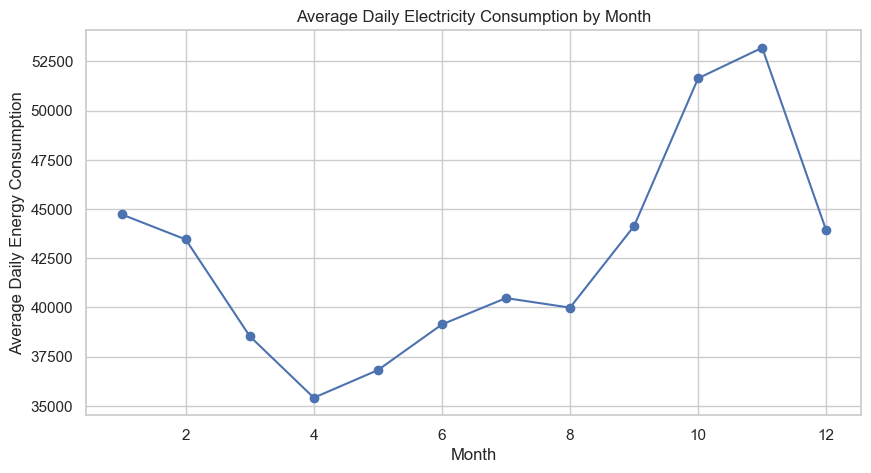

In [23]:
# Step 6.3: Plot monthly seasonality

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg["month"], monthly_avg["energy_sum"], marker="o")
plt.xlabel("Month")
plt.ylabel("Average Daily Energy Consumption")
plt.title("Average Daily Electricity Consumption by Month")
plt.grid(True)
plt.show()


In [24]:
# Step 6.4: Average consumption by weekday
weekday_avg = (
    df_daily
    .groupby("weekday")["energy_sum"]
    .mean()
    .reset_index()
)

weekday_avg


,weekday,energy_sum
0,0,42964.620
1,1,42450.405
2,2,42111.135
3,3,42094.960
4,4,41889.502
5,5,43303.466
6,6,45302.249


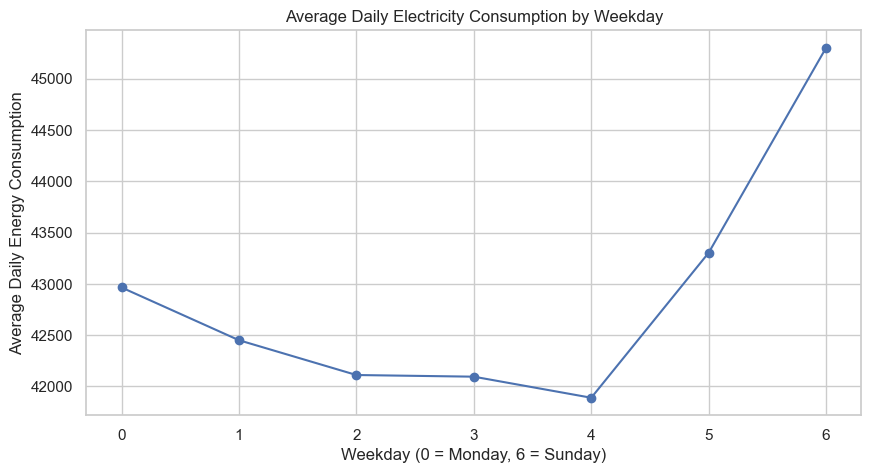

In [25]:
# Step 6.5: Plot weekday patterns

plt.figure(figsize=(10, 5))
plt.plot(weekday_avg["weekday"], weekday_avg["energy_sum"], marker="o")
plt.xlabel("Weekday (0 = Monday, 6 = Sunday)")
plt.ylabel("Average Daily Energy Consumption")
plt.title("Average Daily Electricity Consumption by Weekday")
plt.grid(True)
plt.show()


## Step 6: Temporal Seasonality Analysis (Monthly & Weekly Patterns)

### 6.1 Objective
The goal of this step is to uncover **seasonal and behavioral patterns** in electricity consumption by aggregating daily usage across:
- Months of the year
- Days of the week

Understanding these temporal effects is critical for:
- Feature engineering (month, weekday, seasonality terms)
- Selecting appropriate time-series and regression models
- Designing intuitive Tableau dashboards for stakeholders

---

### 6.2 Monthly Seasonality Insights

We computed the **average daily electricity consumption per month** across all households.

#### Key Observations:
- **Lowest consumption occurs in early spring (March–April)**, with April being the lowest month overall.
- **Consumption rises steadily from late summer into winter**, peaking in **October and November**.
- This pattern strongly suggests **heating-driven demand**, consistent with colder months in the UK.
- December shows a slight drop from November, likely influenced by holiday travel and reduced commercial activity.

#### Implications:
- Month is a **strong predictor** and should be encoded as:
  - Categorical month
  - Seasonal indicator (winter, spring, summer, fall)
- Models should explicitly account for **annual seasonality**.
- Tableau dashboards should highlight **month-over-month trends** and seasonal peaks.

---

### 6.3 Weekly (Day-of-Week) Consumption Patterns

We also examined **average daily consumption by weekday** (0 = Monday, 6 = Sunday).

#### Key Observations:
- **Lowest consumption occurs mid-week (Wednesday–Thursday)**.
- **Consumption increases on weekends**, with **Sunday showing the highest average usage**.
- This reflects behavioral patterns:
  - More time spent at home
  - Increased appliance usage
  - Reduced work-related absences

#### Implications:
- Weekday is a meaningful **behavioral feature**.
- Models that ignore weekday effects may systematically under- or over-predict.
- Tableau dashboards should include:
  - Weekday comparisons
  - Weekend vs weekday segmentation

---

### 6.4 Modeling Readiness Summary

Based on Steps 1–6, the dataset demonstrates:

- Clear **temporal structure**
- Strong **seasonality at multiple time scales**
- Stable aggregation behavior suitable for:
  - Time series forecasting (ARIMA / SARIMA / Prophet-style models)
  - Regression models with calendar-based features
  - Dashboard-driven exploratory analysis

This confirms that **smart meter electricity consumption is a strong and well-justified project topic** for:
- Predictive modeling
- Explainable analytics
- Real-world energy policy and planning applications

---

### 6.5 Next Steps
In the next phase, we will:
- Engineer time-based features explicitly
- Identify and handle edge effects near dataset boundaries
- Begin preparing modeling-ready datasets and Tableau extracts


## Project Roadmap — Post-EDA (After Step 6)

### Current Status (Completed)
- Dataset successfully loaded and validated (3.51M rows, daily aggregation)
- Data types verified and memory footprint understood
- Time range confirmed (Nov 2011 – Feb 2014)
- Missing values, distributions, and summary statistics explored
- Key energy metrics validated:
  - energy_mean
  - energy_sum
  - energy_max
  - energy_min
- Dataset deemed suitable for time series modeling and ML insights

---

## Next Steps Overview

### Step 7 — Feature Engineering (Next Immediate Task)
**Owner: Any teammate**

Goals:
- Convert `day` to datetime (if not already)
- Create time-based features:
  - day_of_week
  - weekend vs weekday
  - month
  - year
- Optional rolling features per household:
  - 7-day rolling mean
  - 30-day rolling mean
- Aggregate or filter households if needed for modeling scale

Deliverable:
- Clean feature-enhanced dataframe ready for modeling

---

## Machine Learning Tasks (Core Graded Component)

### Step 8 — Time Series Prediction Model
**Requirement:** At least one time series forecast

Suggested approach:
- Target variable: `energy_sum` or `energy_mean`
- Model options:
  - Baseline: Linear Regression or ARIMA
  - Advanced: LSTM (preferred if time allows)

Tasks:
- Train / validation split based on time
- Forecast future daily energy usage
- Evaluate with RMSE or MAE

Deliverable:
- Forecast plot
- Error metrics
- Notebook section clearly labeled "Time Series Prediction"

---

### Step 9 — Deep Learning Model (Required)
**Requirement:** One deep learning model built from scratch

Suggested options:
- LSTM predicting daily household energy consumption
- Neural network predicting high-usage vs normal-usage days

Constraints:
- Must be implemented manually (TensorFlow / PyTorch)
- No pre-trained or pre-built architectures

Deliverable:
- Model architecture summary
- Training history
- Prediction visualizations

---

## IoT System Design (Parallel Track)

### Step 10 — Theoretical IoT System Architecture
**Owner: Any teammate (can be non-coding)**

Must include:
- Sensors (smart meters)
- Edge device assumptions
- Network protocol (e.g., MQTT, HTTP)
- Cloud ingestion and storage
- ML inference location (edge vs cloud)

Deliverables:
- System diagram
- Written explanation for report

---

## Dashboard (Final Visualization Layer)

### Step 11 — Tableau Public Dashboard
**Requirement: Minimum 4 visualizations**

Must include:
1. **Status View**
   - Current or most recent energy usage
2. **Historical Summary**
   - Trends over weeks/months
3. **ML Insight #1**
   - Time series forecast visualization
4. **ML Insight #2**
   - Deep learning prediction output

Design notes:
- Consistent color scheme
- Clear labels and titles
- Logical dashboard layout

Deliverable:
- Public Tableau link
- PDF export

---

## Final Deliverables Checklist

### Report (APA, 10–15 pages)
- IoT system design
- EDA summary
- ML methods explanation
- Dashboard design rationale

### Code
- Clean, commented notebook(s)
- GitHub repo with README
- Clear section headers

### Dashboard
- Tableau Public link
- PDF snapshot

---


